### Defining pytorch model 
* **Following pytorch model has one linear layer with `inputs`: 3 and `outputs`:1**
* **Kernel are initialized with He initialization**

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

def create_model():
    class network(nn.Module):
        def __init__(self):
            super(network, self).__init__()
            self.fc1 = nn.Linear(3, 1)#100)
            
        def forward(self, X):
            X = self.fc1(X)#F.linear(self.fc1(X))#, list(self.fc1.parameters())[0])
            return X
    model= network()
    optimizer = optim.Adam(model.parameters())
    criterion= nn.MSELoss()# CrossEntropyLoss()
    return model, optimizer, criterion

In [2]:
model, optimizer, loss= create_model()
model

network(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

#### Data preparation and scaling

        - Each record `X` cosist of first 3 values of 4 values
          from iris dataset input features.
        
        - 4th value serve as taget label `y` .

In [3]:
def scale(arr):
    f= lambda x: (x-np.mean(x))/np.var(x)
    for idx in range(arr.shape[1]):
        arr[:,idx]= f(arr[:, idx])
    #return arr
def plot(v1):
    plt.plot(v1)
    #plt.plot(v2)
    plt.title('Model training loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.legend(['train', 'validation'], loc='upper right')
    return plt.show()

def samp(x, count):#For random batch generation
    idx= np.random.randint(x.shape[0], size=count)
    res = x[idx]
    return res

* **Hessian calculation**

In [4]:
def eval_hessian(loss_grad, model):
    cnt = 0
    for g in loss_grad:
        g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
        cnt = 1
    l = g_vector.size(0)
    hessian = torch.zeros(l, l)
    for idx in range(l):
        grad2rd = torch.autograd.grad(g_vector[idx], model.parameters(), create_graph=True)
        cnt = 0
        for g in grad2rd:
            g2 = g.contiguous().view(-1) if cnt == 0 else torch.cat([g2, g.contiguous().view(-1)])
            cnt = 1
        hessian[idx] = g2
    return hessian.cpu().data.numpy()

#### Model Training & plots

epoch:  0  loss:  2.255631685256958
epoch:  500  loss:  0.48510271310806274
epoch:  1000  loss:  0.3253370523452759
epoch:  1500  loss:  0.294547438621521
epoch:  2000  loss:  0.3795126676559448
epoch:  2500  loss:  0.13330158591270447
epoch:  3000  loss:  0.14958198368549347
epoch:  3500  loss:  0.125545933842659


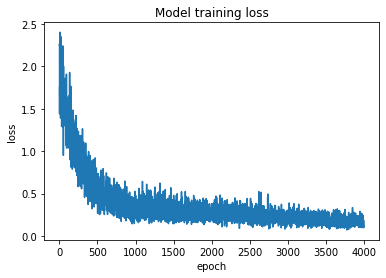

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris()
X, Y = data.data, data.target

Y[np.where(Y==2)[0]]=1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.3)
scale(X)
scale(X_test)

#trainx= Variable(torch.Tensor(X[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
#trainy = Variable(torch.reshape(torch.Tensor(X[:,-1]).float(), (-1,1)))

#i_grads= np.empty(trainx.shape)
wts_bias_progression= list()
all_grads= list()
losses= list()

d2loss_dg= list()
diags= list()
f= lambda x: np.sqrt(np.abs(np.diag(np.linalg.inv(x)))).tolist()

for epoch in range(4000):
    x_ =samp(X, count= 32)
    trainx= Variable(torch.Tensor(x_[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
    trainy = Variable(torch.reshape(torch.Tensor(x_[:,-1]).float(), (-1,1)))

    optimizer.zero_grad()
    y_pred = model(trainx)
    #print(y_pred)
    l = loss(y_pred, trainy)
    losses.append(l.item())
    if epoch%500==0:
        print('epoch: ', epoch, ' loss: ', l.item());
    # perform a backward pass (backpropagation)
    l.backward()
    wts_bias = list(model.parameters())
    wts_bias_vals= torch.cat((wts_bias[0], torch.reshape(wts_bias[1], (-1,1))),1)
    wts_bias_progression.append(wts_bias_vals.tolist())
    
    wts_bias_grads = torch.cat((wts_bias[0].grad, torch.reshape(wts_bias[1].grad, (-1,1))),1)
    #i_grads= trainx.grad
    all_grads.append(wts_bias_grads.tolist())#i_grads)
    # Update the parameters
    optimizer.step()

    d1loss_dg = torch.autograd.grad(loss(model(trainx), trainy), wts_bias, create_graph=True)
    d2loss_dg.append(eval_hessian(d1loss_dg, model))
    diags.append(f(d2loss_dg[-1]))

    
all_wts_bias = np.array(wts_bias_progression).reshape(-1,4)
all_wts_bias_df= pd.DataFrame(all_wts_bias, columns=['weight_{}'.format(idx) for idx in range(1,4)]+ ['bias'])

all_grads = np.array(all_grads).reshape(-1,4)
all_grads_df= pd.DataFrame(all_grads, columns=['beta_{}'.format(idx) for idx in range(1,5)])
plot(losses)

* **Following are the weights and bias for the ONLY layer in model, after 128 epochs**

In [6]:
li = list(model.parameters())
li

[Parameter containing:
 tensor([[ 0.2206, -0.0204,  1.6619]], requires_grad=True),
 Parameter containing:
 tensor([0.0033], requires_grad=True)]

In [7]:
print('Final weights gradients : {}\nFinal bias gradients: {}'.format(li[0].grad, li[1].grad))

Final weights gradients : tensor([[-0.1232, -0.0649, -0.1524]])
Final bias gradients: tensor([0.1111])


#### Gradients across epochs
* **Following are gradients(for weight- Beta_1-3 and bias-beta_4) updated after each epochs**

In [8]:
all_grads_df

,beta_1,beta_2,beta_3,beta_4
0,-3.113537,4.728430,-1.764650,0.645089
1,-2.957298,3.752354,-1.751893,0.476098
2,-2.201695,1.028369,-1.129961,0.351196
3,-3.020661,2.319480,-1.510124,-0.469065
4,-2.643579,1.889900,-1.326816,0.384827
...,...,...,...,...
3995,-0.073219,0.063025,-0.149511,-0.038113
3996,0.226355,0.250348,0.008649,0.220660
3997,0.182689,0.404784,-0.056397,0.239567
3998,-0.023069,0.108271,-0.091278,0.107529


In [9]:
all_grads_df.describe()

,beta_1,beta_2,beta_3,beta_4
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.258508,0.070455,-0.272227,0.013733
std,0.690962,0.568346,0.325690,0.214969
min,-3.684323,-1.582390,-1.868989,-1.173343
25%,-0.319664,-0.241492,-0.310966,-0.117962
50%,-0.040090,-0.003091,-0.167675,0.010169
75%,0.136762,0.265011,-0.081601,0.135245
max,1.257869,4.728430,0.317167,1.789123


### Defining model with statsmodel
* **Evaluating same data with linear regression from statsmodel**

In [10]:
import statsmodels.api as sm
feats, targets= X[:,:-1], X[:,-1]
feats= sm.add_constant(feats, prepend=False)

In [11]:
model_stm = sm.OLS(targets, feats, hasconst=True)
result= model_stm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     734.4
Date:                Thu, 19 Mar 2020   Prob (F-statistic):           7.83e-88
Time:                        20:26:33   Log-Likelihood:                -45.701
No. Observations:                 150   AIC:                             99.40
Df Residuals:                     146   BIC:                             111.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2446      0.056     -4.363      0.0

* **Weights, biases and std_error from modelstats regression model**

In [12]:
summary= result.summary()
result.params

array([-2.44611824e-01,  7.28612405e-02,  2.81096557e+00,  9.36750677e-17])

In [13]:
statsm_df = pd.DataFrame(summary.tables[1].data[1:], columns=summary.tables[1].data[0])
statsm_df

,,coef,std err,t,P>|t|,[0.025,0.975]
0,x1,-0.2446,0.056,-4.363,0.000,-0.355,-0.134
1,x2,0.0729,0.016,4.553,0.000,0.041,0.104
2,x3,2.8110,0.131,21.399,0.000,2.551,3.071
3,const,9.368e-17,0.027,3.45e-15,1.000,-0.054,0.054


* **pytorch_params vs. statsmodel_params**

In [15]:
di = dict(zip('pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr'.split(','), [all_grads[-1,:], all_wts_bias[-1,:], result.params, statsm_df["std err"].values]))#all_grads
di

{'pytorch_grads': array([-0.12322028, -0.06492573, -0.15244903,  0.11112565]),
 'pytorch_params': array([ 0.22076468, -0.02027576,  1.66143763,  0.00375962]),
 'statsmodel_params': array([-2.44611824e-01,  7.28612405e-02,  2.81096557e+00,  9.36750677e-17]),
 'statsmodel_stderr': array(['    0.056', '    0.016', '    0.131', '    0.027'], dtype=object)}

#### Paramters comparison

In [16]:
comp_df = pd.DataFrame(di)
comp_df['pytorch_params'] = comp_df['pytorch_params'].apply(lambda x:np.round(x,3))
comp_df['statsmodel_params'] = comp_df['statsmodel_params'].apply(lambda x:np.round(x,3))
comp_df

,pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr
0,-0.123220,0.221,-0.245,0.056
1,-0.064926,-0.020,0.073,0.016
2,-0.152449,1.661,2.811,0.131
3,0.111126,0.004,0.000,0.027


#### Plots

In [17]:
def scatter_plot(x, y, x_label, y_label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    min_x = min(list(x)+list(y)) - 0.5
    max_x = max(list(x)+list(y)) + 0.5
    ax.plot([min_x, max_x], [min_x, max_x])
    
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_x, max_x])
    
    ax.set_title('{} vs. {} correlation scatterplot'.format(x_label, y_label))
    ax.scatter(x, y, c="red")
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()
    
def hexbin_plot(x, y, x_label, y_label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    min_x = min(list(x)+list(y)) - 0.1
    max_x = max(list(x)+list(y)) + 0.1
    ax.plot([min_x, max_x], [min_x, max_x])
    
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_x, max_x])
    
    ax.set_title('{} vs. {} correlation scatterplot'.format(x_label, y_label))
    hbin= ax.hexbin(x, y, gridsize=25, mincnt=2)
    cb = fig.colorbar(hbin, ax=ax)
    cb.solids.set_edgecolor('face')#change colors
    cb.set_label('occurence_density')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

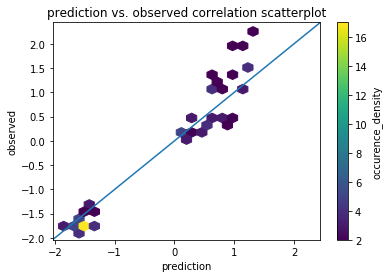

In [18]:
#Plot with trained cases. When predictions are calculated of train_data
predictions= model(torch.Tensor(X[:,:-1]).float())
predictions= torch.Tensor.cpu(predictions).detach().numpy().reshape(-1,)
observed= X[:,-1]


hexbin_plot(predictions,observed, 'prediction' ,'observed')

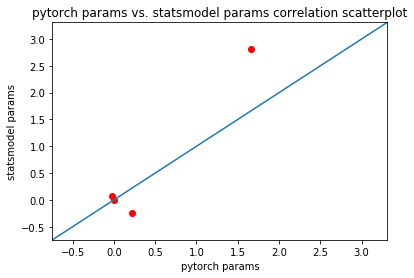

In [19]:
scatter_plot(comp_df['pytorch_params'].values,comp_df['statsmodel_params'].values, 'pytorch params' ,'statsmodel params')#n1,n2, 'abc','bcd')

### Calculating Standard error from pytorch model

In [20]:
mini_batches= list()#contains mini_batches of gradients from 200 epochs
mean_mini_batches= list()#contains mean of each of 200 epochs each in a mini_batches of gradients from 200 epochs
mini_size= 200
for batch in range(1, (len(all_grads))//mini_size):
    mini_batches.append(all_grads[batch*mini_size:batch*mini_size+ mini_size])
    mean_mini_batches.append(list(np.mean(mini_batches[-1], axis=0)))

grad_mini_batch_arr = np.array(mean_mini_batches).T
grad_mini_batch_arr.shape

(4, 19)

In [21]:
covariant_mat= np.cov(grad_mini_batch_arr)
covariant_mat

array([[ 0.20816957, -0.02174   ,  0.09496359, -0.00964174],
       [-0.02174   ,  0.007201  , -0.00989287,  0.00185185],
       [ 0.09496359, -0.00989287,  0.04387188, -0.0043335 ],
       [-0.00964174,  0.00185185, -0.0043335 ,  0.00078766]])

In [22]:
pytorch_stderr= np.sqrt(covariant_mat.diagonal())#**2
pytorch_stderr

array([0.45625604, 0.0848587 , 0.20945616, 0.0280652 ])

In [23]:
di.update({'pytorch_stderr':pytorch_stderr})
comp_df['pytorch_stderr']= pytorch_stderr
comp_df['pytorch_params'] = comp_df['pytorch_params'].apply(lambda x:np.round(x,3))
comp_df['statsmodel_params'] = comp_df['statsmodel_params'].apply(lambda x:np.round(x,3))
comp_df

,pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr,pytorch_stderr
0,-0.123220,0.221,-0.245,0.056,0.456256
1,-0.064926,-0.020,0.073,0.016,0.084859
2,-0.152449,1.661,2.811,0.131,0.209456
3,0.111126,0.004,0.000,0.027,0.028065


### Experiments with configurations

#### Model with xavier normal kernel initialization

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

def create_model_2():
    class network(nn.Module):
        def __init__(self):
            super(network, self).__init__()
            self.fc1 = nn.Linear(3, 1)#100)
            torch.nn.init.xavier_normal_(self.fc1.weight)

        def forward(self, X):
            X = self.fc1(X)#F.linear(self.fc1(X))#, list(self.fc1.parameters())[0])
            return X
    model= network()
    optimizer = optim.Adam(model.parameters())
    criterion= nn.MSELoss()# CrossEntropyLoss()
    return model, optimizer, criterion

model2, optimizer2, loss2= create_model_2()
model2

network(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

##### Model training and comparison plots

epoch:  0  loss:  6.7050395011901855
epoch:  500  loss:  2.35669207572937
epoch:  1000  loss:  1.480225682258606
epoch:  1500  loss:  0.5658202171325684
epoch:  2000  loss:  0.378378689289093
epoch:  2500  loss:  0.26678189635276794
epoch:  3000  loss:  0.18528398871421814
epoch:  3500  loss:  0.11777351796627045


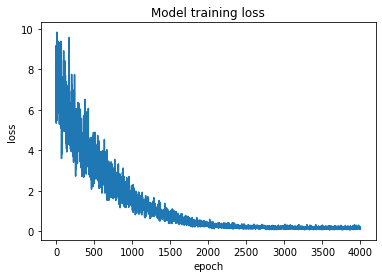

In [25]:
#trainx= Variable(torch.Tensor(X[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
#trainy = Variable(torch.reshape(torch.Tensor(X[:,-1]).float(), (-1,1)))

#i_grads= np.empty(trainx.shape)
wts_bias_progression_2= list()
all_grads_2= list()
losses_2= list()

d2loss_dg2= list()
diags_2= list()
f= lambda x: np.sqrt(np.abs(np.diag(np.linalg.inv(x)))).tolist()
    
for epoch in range(4000):
    x_transformed =samp(X, count= 32)
    trainx= Variable(torch.Tensor(x_transformed[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
    trainy = Variable(torch.reshape(torch.Tensor(x_transformed[:,-1]).float(), (-1,1)))

    optimizer2.zero_grad()
    y_pred = model2(trainx)
    #print(y_pred)
    l = loss2(y_pred, trainy)
    losses_2.append(l.item())
    if epoch%500==0:
        print('epoch: ', epoch, ' loss: ', l.item());
    # perform a backward pass (backpropagation)
    l.backward()
    optimizer2.step()

    wts_bias = list(model2.parameters())
    wts_bias_vals= torch.cat((wts_bias[0], torch.reshape(wts_bias[1], (-1,1))),1)
    wts_bias_progression_2.append(wts_bias_vals.tolist())
    
    wts_bias_grads = torch.cat((wts_bias[0].grad, torch.reshape(wts_bias[1].grad, (-1,1))),1)
    #i_grads= trainx.grad
    all_grads_2.append(wts_bias_grads.tolist())#i_grads)
    # Update the parameters    

    d1loss_dg2 = torch.autograd.grad(loss2(model2(trainx), trainy), wts_bias, create_graph=True)
    d2loss_dg2.append(eval_hessian(d1loss_dg2, model2))
    diags_2.append(f(d2loss_dg2[-1]))

    
all_wts_bias_2 = np.array(wts_bias_progression_2).reshape(-1,4)
all_wts_bias_df_2= pd.DataFrame(all_wts_bias_2, columns=['weight_{}'.format(idx) for idx in range(1,4)]+ ['bias'])

all_grads_2 = np.array(all_grads_2).reshape(-1,4)
all_grads_df_2= pd.DataFrame(all_grads_2, columns=['beta_{}'.format(idx) for idx in range(1,5)])
plot(losses_2)

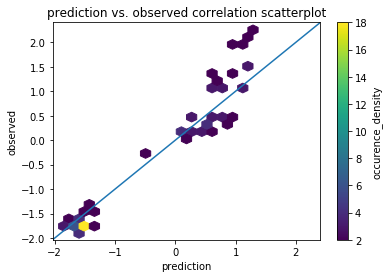

In [26]:
#Plot with trained cases. When predictions are calculated of train_data
predictions= model2(torch.Tensor(X[:,:-1]).float())
predictions= torch.Tensor.cpu(predictions).detach().numpy().reshape(-1,)
observed= X[:,-1]


hexbin_plot(predictions,observed, 'prediction' ,'observed')

##### Pytorch model Standard Error & Parameters Comparison

* **Calculating standard error for pytorch model**

In [27]:
mini_batches_2= list()#contains mini_batches of gradients from 200 epochs
mean_mini_batches_2= list()#contains mean of each of 200 epochs each in a mini_batches of gradients from 200 epochs
mini_size= 200#mini_batch size
for batch in range(1, (len(all_grads_2))//mini_size):
    mini_batches_2.append(all_grads_2[batch*mini_size:batch*mini_size+ mini_size])
    mean_mini_batches_2.append(list(np.mean(mini_batches_2[-1], axis=0)))

grad_mini_batch_arr_2 = np.array(mean_mini_batches_2).T
grad_mini_batch_arr_2.shape

(4, 19)

In [28]:
covariant_mat_2= np.cov(grad_mini_batch_arr_2)
pytorch_stderr_2= np.sqrt(covariant_mat_2.diagonal())
pytorch_stderr_2

array([1.61067696, 0.14686785, 0.67362784, 0.05240117])

In [31]:
di_2 = dict(zip('pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr'.split(','), [all_grads_2[-1,:], all_wts_bias_2[-1,:], result.params, statsm_df["std err"].values]))
di_2.update({'pytorch_stderr':pytorch_stderr_2})
comp_df_2 = pd.DataFrame(di_2)
comp_df_2['pytorch_params'] = comp_df_2['pytorch_params'].apply(lambda x:np.round(x,3))
comp_df_2['statsmodel_params'] = comp_df_2['statsmodel_params'].apply(lambda x:np.round(x,3))
comp_df_2

,pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr,pytorch_stderr
0,-0.037862,0.200,-0.245,0.056,1.610677
1,0.257868,-0.013,0.073,0.016,0.146868
2,-0.086241,1.712,2.811,0.131,0.673628
3,-0.045221,-0.007,0.000,0.027,0.052401


#### Model with xavier_uniform kernel initialization

In [32]:
def create_model_3():
    class network(nn.Module):
        def __init__(self):
            super(network, self).__init__()
            self.fc1 = nn.Linear(3, 1)#100)
            torch.nn.init.xavier_uniform_(self.fc1.weight)

        def forward(self, X):
            X = self.fc1(X)#F.linear(self.fc1(X))#, list(self.fc1.parameters())[0])
            return X
    model= network()
    optimizer = optim.Adam(model.parameters())
    criterion= nn.MSELoss()# CrossEntropyLoss()
    return model, optimizer, criterion

model3, optimizer3, loss3= create_model_3()
model3

network(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

##### Model training and comparison plots

epoch:  0  loss:  0.46982574462890625
epoch:  500  loss:  0.47716012597084045
epoch:  1000  loss:  0.32589447498321533
epoch:  1500  loss:  0.21599262952804565
epoch:  2000  loss:  0.22780176997184753
epoch:  2500  loss:  0.2164819836616516
epoch:  3000  loss:  0.11269696056842804
epoch:  3500  loss:  0.15279187262058258


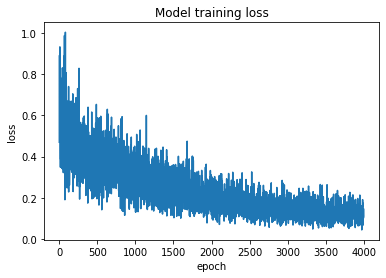

In [33]:
#trainx= Variable(torch.Tensor(X[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
#trainy = Variable(torch.reshape(torch.Tensor(X[:,-1]).float(), (-1,1)))

#i_grads= np.empty(trainx.shape)
wts_bias_progression_3= list()
all_grads_3= list()
losses_3= list()

d2loss_dg3= list()
diags_3= list()
f= lambda x: np.sqrt(np.abs(np.diag(np.linalg.inv(x)))).tolist()    

for epoch in range(4000):
    x_transformed =samp(X, count= 32)
    trainx= Variable(torch.Tensor(x_transformed[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
    trainy = Variable(torch.reshape(torch.Tensor(x_transformed[:,-1]).float(), (-1,1)))

    optimizer3.zero_grad()
    y_pred = model3(trainx)
    #print(y_pred)
    l = loss3(y_pred, trainy)
    losses_3.append(l.item())
    if epoch%500==0:
        print('epoch: ', epoch, ' loss: ', l.item());
    # perform a backward pass (backpropagation)
    l.backward()
    optimizer3.step()
    
    wts_bias = list(model3.parameters())
    wts_bias_vals= torch.cat((wts_bias[0], torch.reshape(wts_bias[1], (-1,1))),1)
    wts_bias_progression_3.append(wts_bias_vals.tolist())
    
    wts_bias_grads = torch.cat((wts_bias[0].grad, torch.reshape(wts_bias[1].grad, (-1,1))),1)
    #i_grads= trainx.grad
    all_grads_3.append(wts_bias_grads.tolist())#i_grads)
    # Update the parameters
    
    d1loss_dg3 = torch.autograd.grad(loss3(model3(trainx), trainy), wts_bias, create_graph=True)
    d2loss_dg3.append(eval_hessian(d1loss_dg3, model3))
    diags_3.append(f(d2loss_dg3[-1]))

    
all_wts_bias_3 = np.array(wts_bias_progression_3).reshape(-1,4)
all_wts_bias_df_3= pd.DataFrame(all_wts_bias_3, columns=['weight_{}'.format(idx) for idx in range(1,4)]+ ['bias'])

all_grads_3 = np.array(all_grads_3).reshape(-1,4)
all_grads_df_3= pd.DataFrame(all_grads_3, columns=['beta_{}'.format(idx) for idx in range(1,5)])
plot(losses_3)

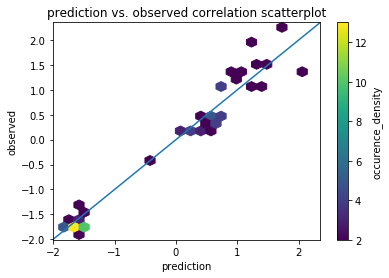

In [34]:
#Plot with trained cases. When predictions are calculated of train_data
predictions= model3(torch.Tensor(X[:,:-1]).float())
predictions= torch.Tensor.cpu(predictions).detach().numpy().reshape(-1,)
observed= X[:,-1]


hexbin_plot(predictions,observed, 'prediction' ,'observed')

##### Pytorch model Standard Error & Parameters Comparison
* **Calculating standard error for pytorch model**

In [35]:
mini_batches_3= list()#contains mini_batches of gradients from 200 epochs
mean_mini_batches_3= list()#contains mean of each of 200 epochs each in a mini_batches of gradients from 200 epochs
mini_size= 200#mini_batch size
for batch in range(1, (len(all_grads_3))//mini_size):
    mini_batches_3.append(all_grads_3[batch*mini_size:batch*mini_size+ mini_size])
    mean_mini_batches_3.append(list(np.mean(mini_batches_3[-1], axis=0)))

grad_mini_batch_arr_3 = np.array(mean_mini_batches_3).T
grad_mini_batch_arr_3.shape

(4, 19)

In [36]:
covariant_mat_3= np.cov(grad_mini_batch_arr_3)
pytorch_stderr_3= np.sqrt(covariant_mat_3.diagonal())
pytorch_stderr_3

array([0.02195155, 0.0489262 , 0.04725731, 0.01132919])

In [38]:
di_3 = dict(zip('pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr'.split(','), [all_grads_3[-1,:], all_wts_bias_3[-1,:], result.params, statsm_df["std err"].values]))
di_3.update({'pytorch_stderr':pytorch_stderr_3})
comp_df_3 = pd.DataFrame(di_3)
comp_df_3['pytorch_params'] = comp_df_3['pytorch_params'].apply(lambda x:np.round(x,3))
comp_df_3['statsmodel_params'] = comp_df_3['statsmodel_params'].apply(lambda x:np.round(x,3))
comp_df_3

,pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr,pytorch_stderr
0,0.055192,-0.031,-0.245,0.056,0.021952
1,-0.425177,0.028,0.073,0.016,0.048926
2,0.034860,2.305,2.811,0.131,0.047257
3,0.186288,0.007,0.000,0.027,0.011329


#### Model training with different data scaling (MinMax)

In [39]:
from sklearn.preprocessing import MinMaxScaler

X, Y = data.data, data.target
sc= MinMaxScaler()
X_trans = sc.fit_transform(X)

Y[np.where(Y==2)[0]]=1
X_train, X_test, y_train, y_test = train_test_split(X_trans, Y, test_size= 0.3)

##### Model training and comparison plots

In [40]:
model4, optimizer4, loss4= create_model()#With default He Weights Initilizing model
model4

network(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

epoch:  0  loss:  0.06816234439611435
epoch:  500  loss:  0.009662216529250145
epoch:  1000  loss:  0.006804624106734991
epoch:  1500  loss:  0.003991321194916964
epoch:  2000  loss:  0.007598560769110918
epoch:  2500  loss:  0.008112939074635506
epoch:  3000  loss:  0.005221005994826555
epoch:  3500  loss:  0.0072307889349758625


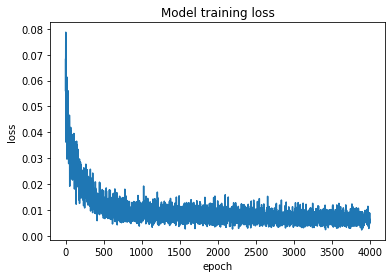

In [41]:
#trainx= Variable(torch.Tensor(X_trans[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
#trainy = Variable(torch.reshape(torch.Tensor(X_trans[:,-1]).float(), (-1,1)))

wts_bias_progression_4= list()
all_grads_4= list()
losses_4= list()
d2loss_dg4= list()
diags_4= list()
f= lambda x: np.sqrt(np.abs(np.diag(np.linalg.inv(x)))).tolist()

for epoch in range(4000):
    x_transformed =samp(X_trans, count= 32)
    trainx= Variable(torch.Tensor(x_transformed[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
    trainy = Variable(torch.reshape(torch.Tensor(x_transformed[:,-1]).float(), (-1,1)))

    optimizer4.zero_grad()
    y_pred = model4(trainx)
    #print(y_pred)
    l = loss4(y_pred, trainy)
    losses_4.append(l.item())
    if epoch%500==0:
        print('epoch: ', epoch, ' loss: ', l.item());
    # perform a backward pass (backpropagation)
    l.backward()
    optimizer4.step()
    
    wts_bias = list(model4.parameters())
    wts_bias_vals= torch.cat((wts_bias[0], torch.reshape(wts_bias[1], (-1,1))),1)
    wts_bias_progression_4.append(wts_bias_vals.tolist())
    
    wts_bias_grads = torch.cat((wts_bias[0].grad, torch.reshape(wts_bias[1].grad, (-1,1))),1)
    all_grads_4.append(wts_bias_grads.tolist())#i_grads)

    d1loss_dg4 = torch.autograd.grad(loss4(model4(trainx), trainy), wts_bias, create_graph=True)
    d2loss_dg4.append(eval_hessian(d1loss_dg4, model4))
    diags_4.append(f(d2loss_dg4[-1]))

all_wts_bias_4 = np.array(wts_bias_progression_4).reshape(-1,4)
all_wts_bias_df_4= pd.DataFrame(all_wts_bias_4, columns=['weight_{}'.format(idx) for idx in range(1,4)]+ ['bias'])

all_grads_4 = np.array(all_grads_4).reshape(-1,4)
all_grads_df_4= pd.DataFrame(all_grads_4, columns=['beta_{}'.format(idx) for idx in range(1,5)])
plot(losses_4)

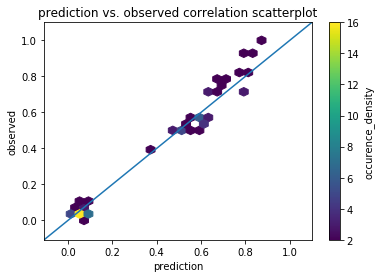

In [42]:
#Plot with trained cases. When predictions are calculated of train_data
predictions= model4(torch.Tensor(X_trans[:,:-1]).float())
predictions= torch.Tensor.cpu(predictions).detach().numpy().reshape(-1,)
observed= X_trans[:,-1]


hexbin_plot(predictions,observed, 'prediction' ,'observed')

##### Retraining Statsmodel model with Scaled data

* **Evaluating same data with linear regression from statsmodel**

Statsmodel model Standard Error & Parameters Comparison

In [43]:
feats, targets= X_trans[:,:-1], X_trans[:,-1]
feats= sm.add_constant(feats, prepend=False)

model_stm_2 = sm.OLS(targets, feats, hasconst=True)
result_2= model_stm_2.fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     734.4
Date:                Thu, 19 Mar 2020   Prob (F-statistic):           7.83e-88
Time:                        20:33:09   Log-Likelihood:                 168.07
No. Observations:                 150   AIC:                            -328.1
Df Residuals:                     146   BIC:                            -316.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3109      0.071     -4.363      0.0

* **Weights, biases and std_error from modelstats regression model**

In [44]:
summary_2= result_2.summary()
result_2.params

array([-0.31089911,  0.22282854,  1.28837099, -0.10908804])

In [45]:
statsm_df_2 = pd.DataFrame(summary_2.tables[1].data[1:], columns=summary_2.tables[1].data[0])
statsm_df_2

,,coef,std err,t,P>|t|,[0.025,0.975]
0,x1,-0.3109,0.071,-4.363,0.000,-0.452,-0.170
1,x2,0.2228,0.049,4.553,0.000,0.126,0.320
2,x3,1.2884,0.060,21.399,0.000,1.169,1.407
3,const,-0.1091,0.027,-4.093,0.000,-0.162,-0.056


##### Pytorch model Standard Error & Parameters Comparison
* **Calculating standard error for pytorch model**

In [46]:
mini_batches_4= list()#contains mini_batches of gradients from 200 epochs
mean_mini_batches_4= list()#contains mean of each of 200 epochs each in a mini_batches of gradients from 200 epochs
mini_size= 200#mini_batch size
for batch in range(1, (len(all_grads_4))//mini_size):
    mini_batches_4.append(all_grads_4[batch*mini_size:batch*mini_size+ mini_size])
    mean_mini_batches_4.append(list(np.mean(mini_batches_4[-1], axis=0)))

grad_mini_batch_arr_4 = np.array(mean_mini_batches_4).T
grad_mini_batch_arr_4.shape

(4, 19)

In [48]:
covariant_mat_4= np.cov(grad_mini_batch_arr_4)
pytorch_stderr_4= np.sqrt(covariant_mat_4.diagonal())
pytorch_stderr_4

array([0.00457705, 0.00710288, 0.01063293, 0.00170027])

In [49]:
di_4 = dict(zip('pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr'.split(','), [all_grads_4[-1,:], all_wts_bias_4[-1,:], result_2.params, statsm_df_2["std err"].values]))
di_4.update({'pytorch_stderr':pytorch_stderr_4})
comp_df_4 = pd.DataFrame(di_4)
comp_df_4['pytorch_params'] = comp_df_4['pytorch_params'].apply(lambda x:np.round(x,3))
comp_df_4['statsmodel_params'] = comp_df_4['statsmodel_params'].apply(lambda x:np.round(x,3))
comp_df_4

,pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr,pytorch_stderr
0,0.002249,-0.132,-0.311,0.071,0.004577
1,0.002563,0.126,0.223,0.049,0.007103
2,0.003002,1.136,1.288,0.060,0.010633
3,0.008814,-0.074,-0.109,0.027,0.001700


#### Model training with reference Weights from statsmodel

In [50]:
ref_kernel = torch.reshape(torch.Tensor(result_2.params[:-1]+ np.random.normal(0,0.1, result_2.params[:-1].shape[0])).float(), (1,-1))
ref_bias = result_2.params[-1] + 0.1#Adding noise

In [51]:
def create_model_5():
    class network(nn.Module):
        def __init__(self):
            super(network, self).__init__()
            self.fc1 = nn.Linear(3, 1)#100)
            self.fc1.weight= torch.nn.Parameter(ref_kernel)
            #torch.nn.init.constant_(ref_kernel,0.3)
            #self.fc1.weight.data= ref_kernel
            self.fc1.bias.data.fill_(ref_bias)
            #torch.nn.init.xavier_uniform_(self.fc1.weight)

        def forward(self, X):
            X = self.fc1(X)#F.linear(self.fc1(X))#, list(self.fc1.parameters())[0])
            return X
    model= network()
    optimizer = optim.Adam(model.parameters())#LBFGS(model.parameters())
    criterion= nn.MSELoss()# CrossEntropyLoss()
    return model, optimizer, criterion

model5, optimizer5, loss5= create_model_5()
model5

network(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

In [52]:
result_2.params#refrenced weights, bias from statsmodel

array([-0.31089911,  0.22282854,  1.28837099, -0.10908804])

In [53]:
list(model5.parameters())

[Parameter containing:
 tensor([[-0.1212,  0.2014,  1.3023]], requires_grad=True),
 Parameter containing:
 tensor([-0.0091], requires_grad=True)]

epoch:  0  loss:  0.04628120735287666
epoch:  500  loss:  0.006706902291625738
epoch:  1000  loss:  0.006457014940679073
epoch:  1500  loss:  0.005930973216891289
epoch:  2000  loss:  0.006694471929222345
epoch:  2500  loss:  0.007804044522345066
epoch:  3000  loss:  0.006971283350139856
epoch:  3500  loss:  0.004248933866620064


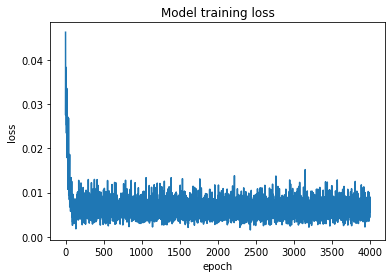

In [54]:
#trainx= Variable(torch.Tensor(X_trans[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
#trainy = Variable(torch.reshape(torch.Tensor(X_trans[:,-1]).float(), (-1,1)))

wts_bias_progression_5= list()
all_grads_5= list()
losses_5= list()
d2loss_dg5= list()
diags_5= list()
f= lambda x: np.sqrt(np.abs(np.diag(np.linalg.inv(x)))).tolist()


for epoch in range(4000):
    x_transformed =samp(X_trans, count= 32)
    trainx= Variable(torch.Tensor(x_transformed[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
    trainy = Variable(torch.reshape(torch.Tensor(x_transformed[:,-1]).float(), (-1,1)))

    optimizer5.zero_grad()
    y_pred = model5(trainx)
    #print(y_pred)
    l = loss5(y_pred, trainy)
    losses_5.append(l.item())
    if epoch%500==0:
        print('epoch: ', epoch, ' loss: ', l.item());
    # perform a backward pass (backpropagation)
    l.backward()
    optimizer5.step()

    wts_bias = list(model5.parameters())
    wts_bias_vals= torch.cat((wts_bias[0], torch.reshape(wts_bias[1], (-1,1))),1)
    wts_bias_progression_5.append(wts_bias_vals.tolist())
    
    wts_bias_grads = torch.cat((wts_bias[0].grad, torch.reshape(wts_bias[1].grad, (-1,1))),1)
    all_grads_5.append(wts_bias_grads.tolist())#i_grads)
        
    d1loss_dg5 = torch.autograd.grad(loss5(model5(trainx), trainy), wts_bias, create_graph=True)
    d2loss_dg5.append(eval_hessian(d1loss_dg5, model5))
    diags_5.append(f(d2loss_dg5[-1]))

all_wts_bias_5 = np.array(wts_bias_progression_5).reshape(-1,4)
all_wts_bias_df_5= pd.DataFrame(all_wts_bias_5, columns=['weight_{}'.format(idx) for idx in range(1,4)]+ ['bias'])

all_grads_5 = np.array(all_grads_5).reshape(-1,4)
all_grads_df_5= pd.DataFrame(all_grads_5, columns=['beta_{}'.format(idx) for idx in range(1,5)])
plot(losses_5)

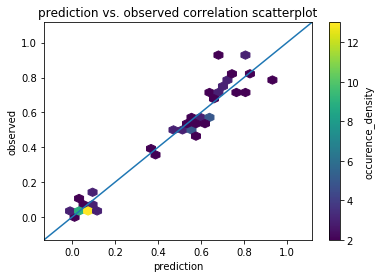

In [55]:
#Plot with trained cases. When predictions are calculated of train_data
predictions= model5(torch.Tensor(X_trans[:,:-1]).float())
predictions= torch.Tensor.cpu(predictions).detach().numpy().reshape(-1,)
observed= X_trans[:,-1]


hexbin_plot(predictions,observed, 'prediction' ,'observed')

##### Pytorch model Standard Error & Parameters Comparison
* **Calculating standard error for pytorch model**

In [56]:
mini_batches_5= list()#contains mini_batches of gradients from 200 epochs
mean_mini_batches_5= list()#contains mean of each of 200 epochs each in a mini_batches of gradients from 200 epochs
mini_size= 200#mini_batch size
for batch in range(1, (len(all_grads_5))//mini_size):
    mini_batches_5.append(all_grads_5[batch*mini_size:batch*mini_size+ mini_size])
    mean_mini_batches_5.append(list(np.mean(mini_batches_5[-1], axis=0)))

grad_mini_batch_arr_5 = np.array(mean_mini_batches_5).T
grad_mini_batch_arr_5.shape

(4, 19)

In [57]:
covariant_mat_5= np.cov(grad_mini_batch_arr_5)
pytorch_stderr_5= np.sqrt(covariant_mat_5.diagonal())#**2
pytorch_stderr_5

array([0.00083488, 0.00091997, 0.00108462, 0.00088453])

In [58]:
di_5 = dict(zip('pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr'.split(','), [all_grads_5[-1,:], all_wts_bias_5[-1,:], result_2.params, statsm_df_2["std err"].values]))
di_5.update({'pytorch_stderr':pytorch_stderr_5})
comp_df_5 = pd.DataFrame(di_5)
comp_df_5['pytorch_params'] = comp_df_5['pytorch_params'].apply(lambda x:np.round(x,3))
comp_df_5['statsmodel_params'] = comp_df_5['statsmodel_params'].apply(lambda x:np.round(x,3))
comp_df_5

,pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr,pytorch_stderr
0,0.005294,-0.281,-0.311,0.071,0.000835
1,0.004015,0.212,0.223,0.049,0.000920
2,-0.001860,1.270,1.288,0.060,0.001085
3,-0.011167,-0.105,-0.109,0.027,0.000885


#### Model training with LBFGS optimizer and all previously tried settings


##### LBFGS optimizer with Reference statsmodel weights & bias (Exp 4.4)

In [59]:
ref_kernel = torch.reshape(torch.Tensor(result_2.params[:-1]+ np.random.normal(0,0.1, result_2.params[:-1].shape[0])).float(), (1,-1))
ref_bias = result_2.params[-1] + 0.1#Adding noise

In [60]:
def create_model_6():
    class network(nn.Module):
        def __init__(self):
            super(network, self).__init__()
            self.fc1 = nn.Linear(3, 1)#100)
            self.fc1.weight= torch.nn.Parameter(ref_kernel)
            #torch.nn.init.constant_(ref_kernel,0.3)
            #self.fc1.weight.data= ref_kernel
            self.fc1.bias.data.fill_(ref_bias)
            #torch.nn.init.xavier_uniform_(self.fc1.weight)

        def forward(self, X):
            X = self.fc1(X)#F.linear(self.fc1(X))#, list(self.fc1.parameters())[0])
            return X
    model= network()
    optimizer = optim.LBFGS(model.parameters())
    criterion= nn.MSELoss()# CrossEntropyLoss()
    return model, optimizer, criterion

model6, optimizer6, loss6= create_model_6()
model6

network(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

In [61]:
list(model6.parameters())

[Parameter containing:
 tensor([[-0.2720,  0.4067,  1.2206]], requires_grad=True),
 Parameter containing:
 tensor([-0.0091], requires_grad=True)]

epoch:  0  loss:  0.0358392633497715
epoch:  500  loss:  0.009032264351844788
epoch:  1000  loss:  0.00557086942717433
epoch:  1500  loss:  0.0115624088793993
epoch:  2000  loss:  0.006967869121581316
epoch:  2500  loss:  0.005488941445946693
epoch:  3000  loss:  0.007779022213071585
epoch:  3500  loss:  0.005351852625608444


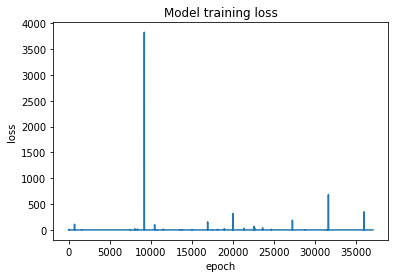

In [62]:
#trainx= Variable(torch.Tensor(X_trans[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
#trainy = Variable(torch.reshape(torch.Tensor(X_trans[:,-1]).float(), (-1,1)))
def report_loss(ep, loss_any, pred, obs):
    ls = loss_any(pred, obs)
    if ep%500==0:
        print('epoch: ', ep, ' loss: ', ls.item())


wts_bias_progression_6= list()
all_grads_6= list()
losses_6= list()
d2loss_dg6= list()
diags_6= list()
f= lambda x: np.sqrt(np.abs(np.diag(np.linalg.inv(x)))).tolist()

for epoch in range(4000):
    x_transformed =samp(X_trans, count= 32)
    trainx= Variable(torch.Tensor(x_transformed[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
    trainy = Variable(torch.reshape(torch.Tensor(x_transformed[:,-1]).float(), (-1,1)))

    def closure():
        optimizer6.zero_grad()
        y_pred = model6(trainx)

        l = loss6(y_pred, trainy)
        losses_6.append(l.item())
        #if epoch%500==0:
        #    print('epoch: ', epoch, ' loss: ', l.item());
        # perform a backward pass (backpropagation)
        l.backward()
        return l
    report_loss(epoch, loss6, model6(trainx), trainy)
    optimizer6.step(closure)

    wts_bias = list(model6.parameters())
    wts_bias_vals= torch.cat((wts_bias[0], torch.reshape(wts_bias[1], (-1,1))),1)
    wts_bias_progression_6.append(wts_bias_vals.tolist())

    #print('(torch.reshape(wts_bias[1].grad, (-1,1))),1):',epoch, type(wts_bias[1].grad))
    wts_bias_grads = torch.cat((wts_bias[0].grad, torch.reshape(wts_bias[1].grad, (-1,1))),1)
    all_grads_6.append(wts_bias_grads.tolist())#i_grads)
    
    d1loss_dg6 = torch.autograd.grad(loss6(model6(trainx), trainy), wts_bias, create_graph=True)
    d2loss_dg6.append(eval_hessian(d1loss_dg6, model6))
    diags_6.append(f(d2loss_dg6[-1]))

    

all_wts_bias_6 = np.array(wts_bias_progression_6).reshape(-1,4)
all_wts_bias_df_6= pd.DataFrame(all_wts_bias_6, columns=['weight_{}'.format(idx) for idx in range(1,4)]+ ['bias'])

all_grads_6 = np.array(all_grads_6).reshape(-1,4)
all_grads_df_6= pd.DataFrame(all_grads_6, columns=['beta_{}'.format(idx) for idx in range(1,5)])
plot(losses_6)

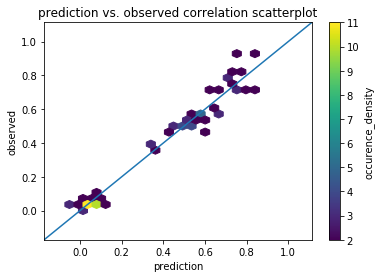

In [63]:
#Plot with trained cases. When predictions are calculated of train_data
predictions= model6(torch.Tensor(X_trans[:,:-1]).float())
predictions= torch.Tensor.cpu(predictions).detach().numpy().reshape(-1,)
observed= X_trans[:,-1]

hexbin_plot(predictions,observed, 'prediction' ,'observed')

###### Pytorch model Standard Error & Parameters Comparison
* **Calculating standard error for pytorch model**

In [64]:
mini_batches_6= list()#contains mini_batches of gradients from 200 epochs
mean_mini_batches_6= list()#contains mean of each of 200 epochs each in a mini_batches of gradients from 200 epochs
mini_size= 200#mini_batch size
for batch in range(1, (len(all_grads_6))//mini_size):
    mini_batches_6.append(all_grads_6[batch*mini_size:batch*mini_size+ mini_size])
    mean_mini_batches_6.append(list(np.mean(mini_batches_6[-1], axis=0)))

grad_mini_batch_arr_6 = np.array(mean_mini_batches_6).T
grad_mini_batch_arr_6.shape

(4, 19)

In [65]:
covariant_mat_6= np.cov(grad_mini_batch_arr_6)
pytorch_stderr_6= np.sqrt(covariant_mat_6.diagonal())#**2
pytorch_stderr_6

array([0.00049518, 0.00045562, 0.00056496, 0.00081083])

In [66]:
di_6 = dict(zip('pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr'.split(','), [all_grads_6[-1,:], all_wts_bias_6[-1,:], result_2.params, statsm_df_2["std err"].values]))
di_6.update({'pytorch_stderr':pytorch_stderr_6})
comp_df_6 = pd.DataFrame(di_6)
comp_df_6['pytorch_params'] = comp_df_6['pytorch_params'].apply(lambda x:np.round(x,3))
comp_df_6['statsmodel_params'] = comp_df_6['statsmodel_params'].apply(lambda x:np.round(x,3))
comp_df_6

,pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr,pytorch_stderr
0,8.310700e-07,-0.459,-0.311,0.071,0.000495
1,3.807924e-06,0.328,0.223,0.049,0.000456
2,4.189713e-07,1.410,1.288,0.060,0.000565
3,4.556961e-06,-0.160,-0.109,0.027,0.000811


##### LBFGS optimizer with Xavier kernel init (Exp 4.1)

In [67]:
def create_model_7():
    class network(nn.Module):
        def __init__(self):
            super(network, self).__init__()
            self.fc1 = nn.Linear(3, 1)
            torch.nn.init.xavier_uniform_(self.fc1.weight)

        def forward(self, X):
            X = self.fc1(X)#F.linear(self.fc1(X))#, list(self.fc1.parameters())[0])
            return X
    model= network()
    optimizer = optim.LBFGS(model.parameters())
    criterion= nn.MSELoss()# CrossEntropyLoss()
    return model, optimizer, criterion

model7, optimizer7, loss7= create_model_7()
model7

network(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

epoch:  0  loss:  0.2515413463115692
epoch:  500  loss:  0.01371206808835268
epoch:  1000  loss:  0.008589252829551697
epoch:  1500  loss:  0.006381518207490444
epoch:  2000  loss:  0.00470005115494132
epoch:  2500  loss:  0.008985985070466995
epoch:  3000  loss:  0.005079461727291346
epoch:  3500  loss:  0.007732025347650051


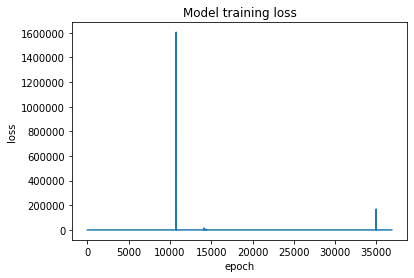

In [68]:
#trainx= Variable(torch.Tensor(X_trans[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
#trainy = Variable(torch.reshape(torch.Tensor(X_trans[:,-1]).float(), (-1,1)))
def report_loss(ep, loss_any, pred, obs):
    ls = loss_any(pred, obs)
    if ep%500==0:
        print('epoch: ', ep, ' loss: ', ls.item())

wts_bias_progression_7= list()
all_grads_7= list()
losses_7= list()
d2loss_dg7= list()
diags_7= list()
f= lambda x: np.sqrt(np.abs(np.diag(np.linalg.inv(x)))).tolist()

for epoch in range(4000):
    x_transformed =samp(X_trans, count= 32)
    trainx= Variable(torch.Tensor(x_transformed[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
    trainy = Variable(torch.reshape(torch.Tensor(x_transformed[:,-1]).float(), (-1,1)))

    def closure():
        optimizer7.zero_grad()
        y_pred = model7(trainx)

        l = loss7(y_pred, trainy)
        losses_7.append(l.item())
        #if epoch%500==0:
        #    print('epoch: ', epoch, ' loss: ', l.item());
        # perform a backward pass (backpropagation)
        l.backward()
        return l
    report_loss(epoch, loss7, model7(trainx), trainy)
    optimizer7.step(closure)

    wts_bias = list(model7.parameters())
    wts_bias_vals= torch.cat((wts_bias[0], torch.reshape(wts_bias[1], (-1,1))),1)
    wts_bias_progression_7.append(wts_bias_vals.tolist())

    #print('(torch.reshape(wts_bias[1].grad, (-1,1))),1):',epoch, type(wts_bias[1].grad))
    wts_bias_grads = torch.cat((wts_bias[0].grad, torch.reshape(wts_bias[1].grad, (-1,1))),1)
    all_grads_7.append(wts_bias_grads.tolist())#i_grads)

    d1loss_dg7 = torch.autograd.grad(loss7(model7(trainx), trainy), wts_bias, create_graph=True)
    d2loss_dg7.append(eval_hessian(d1loss_dg7, model7))
    diags_7.append(f(d2loss_dg7[-1]))
    
all_wts_bias_7 = np.array(wts_bias_progression_7).reshape(-1,4)
all_wts_bias_df_7= pd.DataFrame(all_wts_bias_7, columns=['weight_{}'.format(idx) for idx in range(1,4)]+ ['bias'])

all_grads_7 = np.array(all_grads_7).reshape(-1,4)
all_grads_df_7= pd.DataFrame(all_grads_7, columns=['beta_{}'.format(idx) for idx in range(1,5)])
plot(losses_7)

###### Pytorch model Standard Error & Parameters Comparison
* **Calculating standard error for pytorch model**

In [69]:
mini_batches_7= list()#contains mini_batches of gradients from 200 epochs
mean_mini_batches_7= list()#contains mean of each of 200 epochs each in a mini_batches of gradients from 200 epochs
mini_size= 200#mini_batch size
for batch in range(1, (len(all_grads_7))//mini_size):
    mini_batches_7.append(all_grads_7[batch*mini_size:batch*mini_size+ mini_size])
    mean_mini_batches_7.append(list(np.mean(mini_batches_7[-1], axis=0)))

grad_mini_batch_arr_7 = np.array(mean_mini_batches_7).T
grad_mini_batch_arr_7.shape

(4, 19)

In [70]:
covariant_mat_7= np.cov(grad_mini_batch_arr_7)
pytorch_stderr_7= np.sqrt(covariant_mat_7.diagonal())#**2
pytorch_stderr_7

array([0.00049976, 0.00041569, 0.00048773, 0.0007498 ])

In [71]:
di_7 = dict(zip('pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr'.split(','), [all_grads_7[-1,:], all_wts_bias_7[-1,:], result_2.params, statsm_df_2["std err"].values]))
di_7.update({'pytorch_stderr':pytorch_stderr_7})
comp_df_7 = pd.DataFrame(di_7)
comp_df_7['pytorch_params'] = comp_df_7['pytorch_params'].apply(lambda x:np.round(x,3))
comp_df_7['statsmodel_params'] = comp_df_7['statsmodel_params'].apply(lambda x:np.round(x,3))
comp_df_7

,pytorch_grads,pytorch_params,statsmodel_params,statsmodel_stderr,pytorch_stderr
0,-0.006372,-0.427,-0.311,0.071,0.000500
1,-0.001193,0.274,0.223,0.049,0.000416
2,-0.005726,1.408,1.288,0.060,0.000488
3,-0.007879,-0.136,-0.109,0.027,0.000750


_________________________